# Bayesian Hyperparameter Optimization
---

The `scikit-optimize` project offers powerful sequential model-based optimization algorithms. This package can be leveraged to optimize the BDT hyperparameters or other use cases in our analysis where there is a computationally costly objective whose parameters we would like to optimize.

In [1]:
import numpy
import pandas
import skopt
from skopt.plots import plot_convergence
from skopt.space import Categorical, Integer, Real, Space
from skopt.utils import use_named_args

from utils import TMVAClassifier

%matplotlib inline

Welcome to JupyROOT 6.10/09


## Defining a Hyperparameter Space
---

More documentation to follow.

In [2]:
HYPERPARAMETERS = Space([
    Integer(1, 2000, name='NTrees'),
    Integer(2, 20, name='MaxDepth'),
    Real(0.1, 20, name='MinNodeSize'),
    Integer(2, 50, name='nCuts'),
    Categorical(['Grad'], name='BoostType'),
    Real(10**-4, 10**0, prior='log-uniform', name='Shrinkage'),
    Real(0.1, 1, name='NodePurityLimit'),
    Categorical([True, False], name='UseBaggedBoost'),
    Real(0.1, 1, name='BaggedSampleFraction'),
    Categorical(['CrossEntropy', 'GiniIndex', 'MisClassificationError', 'SDivSqrtSPlusB'], name='SeparationType'),
])

## Defining an Objective Function
---

More documentation to follow.

In [3]:
# Load training and test data.
df_train = pandas.read_hdf('0lepton_2016.h5', key='train')
df_train['label'] = df_train['sample'].map(lambda x: 1 if x in ['ZH', 'ggZH', 'WminusH', 'WplusH'] else 0)
df_train['SA5'] = pandas.to_numeric(df_train['SA5'])

df_test = pandas.read_hdf('0lepton_2016.h5', key='test')
df_test['label'] = df_test['sample'].map(lambda x: 1 if x in ['ZH', 'ggZH', 'WminusH', 'WplusH'] else 0)
df_test['SA5'] = pandas.to_numeric(df_test['SA5'])

X_train, w_train, y_train = df_train.loc[:, :'SA5'], df_train.loc[:, 'event_weight'], df_train.loc[:, 'label']
X_test, w_test, y_test = df_test.loc[:, :'SA5'], df_test.loc[:, 'event_weight'], df_test.loc[:, 'label']

In [4]:
@use_named_args(HYPERPARAMETERS.dimensions)
def objective(**params):
    model = TMVAClassifier(method='BDT', **params)
    print 'Evaluating objective for {0!r}\n'.format(model)
    metrics = model.cross_val(X_train, y_train, weights=w_train, validation_data=(X_test, y_test, w_test), n_folds=2)
    # The following line is necessary for the minimization routine
    # to repeatedly call the objective function without crashing.
    del model
    # Note that a negative sign may be necessary depending on the context
    # of the problem because the optimizers are all minimizers.
    return -numpy.mean(metrics['auroc'])

## Optimizing the Objective
---

More documentation to follow.

In [5]:
result = skopt.gp_minimize(objective, HYPERPARAMETERS.dimensions, n_calls=25, n_random_starts=10)

# Always good to make sure the results you've been waiting for are properly stored.
skopt.dump(result, filename='result.pkl', store_objective=False)

result = skopt.load('result.pkl')

Evaluating objective for TMVAClassifier(method='BDT', NTrees=685, Shrinkage=0.012970292786793958, nCuts=14, UseBaggedBoost=True, MinNodeSize=11.222032620560748, BaggedSampleFraction=0.33044380871910106, NodePurityLimit=0.46446492597071054, MaxDepth=9, BoostType='Grad', SeparationType='GiniIndex')

Evaluating objective for TMVAClassifier(method='BDT', NTrees=265, Shrinkage=0.00049162916469202829, nCuts=26, UseBaggedBoost=False, MinNodeSize=5.202377405111859, BaggedSampleFraction=0.81070620759947876, NodePurityLimit=0.18976823829524883, MaxDepth=11, BoostType='Grad', SeparationType='CrossEntropy')

Evaluating objective for TMVAClassifier(method='BDT', NTrees=34, Shrinkage=0.87553240601108229, nCuts=2, UseBaggedBoost=True, MinNodeSize=5.5837778245295864, BaggedSampleFraction=0.18129585378582375, NodePurityLimit=0.83385193391558277, MaxDepth=16, BoostType='Grad', SeparationType='SDivSqrtSPlusB')

Evaluating objective for TMVAClassifier(method='BDT', NTrees=1853, Shrinkage=0.041219345089288

In [6]:
best_hyperparameters = '\n'.join('{0}={1!s}'.format(d.name, val) for d, val in zip(HYPERPARAMETERS.dimensions, result.x))
print 'The best objective value was {0!s}, which corresponded to the following hyperparameters:\n{1}'.format(result.fun, best_hyperparameters)

The best objective value was -0.867260217667, which corresponded to the following hyperparameters:
NTrees=1119
MaxDepth=19
MinNodeSize=0.859274975399
nCuts=31
BoostType=Grad
Shrinkage=0.00627077737308
NodePurityLimit=0.701284287679
UseBaggedBoost=True
BaggedSampleFraction=0.284360042277
SeparationType=SDivSqrtSPlusB


## Visualizing the Results
---

More documentation to follow.

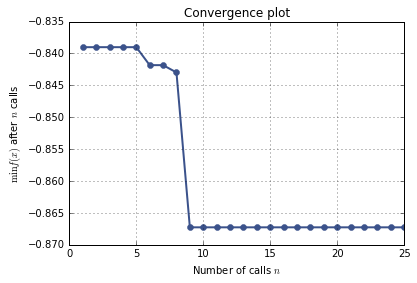

In [7]:
plot_convergence(result);